# India's Lower Judiciary

Understanding [recent progress in India's lower judiciary](https://pratapvardhan.com/blog/india-lower-judiciary/) by looking at data of [38 million cases](http://www.devdatalab.org/judicial-data) filed between 2013-2016

[@PratapVardhan](https://twitter.com/PratapVardhan)


#### Download Data

Downlload data from [devdatalab](http://www.devdatalab.org/judicial-data) and extract csv files and place then under `csv` folder

We'll primilraly use [pandas](https://pandas.pydata.org/) for data processing, and analysis

In [1]:
import time
import pandas as pd

#### Metadata Keys
We would need mapping for `state_code` and `state_name`

In [2]:
df_states = pd.read_csv('csv/keys/cases_state_key.csv')
df_states.head()

,year,state_code,state_name
0,2010,1,Maharashtra
1,2010,2,Andhra Pradesh
2,2010,3,Karnataka
3,2010,4,Kerala
4,2010,5,Himachal Pradesh


#### Census
We'll use 2011 census for state populations

In [3]:
src = 'https://github.com/pratapvardhan/data/raw/master/census-india/primary-census-india-states.csv'
df_census = pd.read_csv(src, usecols=['State Name', 'TOT_P'])
replace = {'Nct Of Delhi': 'Delhi', 'Jammu & Kashmir': 'Jammu and Kashmir', 'Odisha': 'Orissa'}
df_census['state_name'] = df_census['State Name'].str.title().replace(replace)
df_census.head()

,State Name,TOT_P,state_name
0,JAMMU & KASHMIR,12541302,Jammu and Kashmir
1,HIMACHAL PRADESH,6864602,Himachal Pradesh
2,PUNJAB,27743338,Punjab
3,CHANDIGARH,1055450,Chandigarh
4,UTTARAKHAND,10086292,Uttarakhand


and get the regions mapping for states

In [4]:
df_codes = pd.read_csv('https://github.com/pratapvardhan/data/raw/master/census-india/state-codes.csv')
df_codes.head()

,state_name,state_2code,regions
0,Andhra Pradesh,AP,South
1,Arunachal Pradesh,AR,Northeast
2,Assam,AS,Northeast
3,Bihar,BR,East
4,Chhattisgarh,CT,Central


#### Dive into data
We'll just need `['year', 'state_code', 'dist_code', 'date_of_filing', 'date_of_decision']` columns, so we'll read just them. For now, let's just read 2016 file.

In [5]:
%%time
usecols = ['year', 'state_code', 'dist_code', 'date_of_filing', 'date_of_decision']
df = pd.read_csv('csv/cases/cases_2016.csv', usecols=usecols)

Wall time: 13.3 s


In [6]:
print(df.columns)
df.head().T

Index(['year', 'state_code', 'dist_code', 'date_of_filing',
       'date_of_decision'],
      dtype='object')


,0,1,2,3,4
year,2016,2016,2016,2016,2016
state_code,1,1,1,1,1
dist_code,25,20,23,25,8
date_of_filing,2016-01-27,2016-03-09,2016-05-11,2016-05-03,2016-06-24
date_of_decision,2018-05-19,2018-10-03,2019-11-21,2016-11-09,2018-12-12


#### Cleaning
Certain dates are not valid, few cases have `date_of_filing` after `date_of_decision` 😕. We'll ignore these. 

And, merge the `df_states` for state name

In [7]:
for c in ['date_of_filing', 'date_of_decision']:
    df[f'dt_{c}'] = pd.to_datetime(df[c], errors='coerce', format='%Y-%m-%d')

date_errors = df['dt_date_of_decision'].isnull() & df['date_of_decision'].notnull()
print(df.shape[0])
df = df[~date_errors]
print(df.shape[0])
df['days_to_decision'] = (df['dt_date_of_decision'] - df['dt_date_of_filing']).dt.days
df = df[~df['days_to_decision'].lt(0)]
print(df.shape[0])
df = df.merge(df_states)
df.head().T

11349260
11349196
11315048


,0,1,2,3,4
year,2016,2016,2016,2016,2016
state_code,1,1,1,1,1
dist_code,25,20,23,25,8
date_of_filing,2016-01-27,2016-03-09,2016-05-11,2016-05-03,2016-06-24
date_of_decision,2018-05-19,2018-10-03,2019-11-21,2016-11-09,2018-12-12
dt_date_of_filing,2016-01-27 00:00:00,2016-03-09 00:00:00,2016-05-11 00:00:00,2016-05-03 00:00:00,2016-06-24 00:00:00
dt_date_of_decision,2018-05-19 00:00:00,2018-10-03 00:00:00,2019-11-21 00:00:00,2016-11-09 00:00:00,2018-12-12 00:00:00
days_to_decision,843.0,938.0,1289.0,190.0,901.0
state_name,Maharashtra,Maharashtra,Maharashtra,Maharashtra,Maharashtra


... just check how values are

In [8]:
df['days_to_decision'].isnull().sum(), df['days_to_decision'].lt(0).sum(), df['days_to_decision'].ge(0).sum(), df.shape[0]

(3259272, 0, 8055776, 11315048)

#### Summary
At state level, we'll find out `total_cases`, cases decided `within_2years` and `%within_2years`

In [9]:
dff = df.groupby('state_name', as_index=False).agg(
    total_cases=pd.NamedAgg(column='state_name', aggfunc='count'),
    within_2years=pd.NamedAgg(column='days_to_decision', aggfunc=lambda x: x.lt(365*2).sum())
)
dff['%within_2years'] = (dff['within_2years'] / dff['total_cases']) * 100
dff

,state_name,total_cases,within_2years,%within_2years
0,Andhra Pradesh,273022,171436.0,62.792009
1,Assam,155760,108185.0,69.456215
2,Bihar,388926,172341.0,44.312029
3,Chandigarh,29782,23582.0,79.182056
4,Chhattisgarh,179109,129024.0,72.036581
5,DNH at Silvasa,1006,776.0,77.137177
6,Delhi,308441,198785.0,64.448306
7,Diu and Daman,1589,1498.0,94.273128
8,Goa,31344,24423.0,77.919219
9,Gujarat,734738,572095.0,77.863810


Let's merge `df_census` and calculate `cases_per_1L` population

In [10]:
dff = dff.merge(df_census[['state_name', 'TOT_P']])
dff['cases_per_1L'] = (dff['total_cases'] / dff['TOT_P'] * 1_00_000).round(0)
dff.sort_values(by='cases_per_1L', ascending=False)

,state_name,total_cases,within_2years,%within_2years,TOT_P,cases_per_1L
3,Chandigarh,29782,23582.0,79.182056,1055450,2822.0
13,Kerala,809727,548878.0,67.785562,33406061,2424.0
8,Haryana,571403,449178.0,78.609668,25351462,2254.0
6,Goa,31344,24423.0,77.919219,1458545,2149.0
5,Delhi,308441,198785.0,64.448306,16787941,1837.0
12,Karnataka,1073475,808623.0,75.327604,61095297,1757.0
9,Himachal Pradesh,110027,70719.0,64.274224,6864602,1603.0
20,Punjab,441788,345884.0,78.291850,27743338,1592.0
7,Gujarat,734738,572095.0,77.863810,60439692,1216.0
15,Maharashtra,1246120,719598.0,57.747087,112374333,1109.0


Let's wrap all this into a function, to create summaries for each year

In [11]:
def make_summary(year):
    usecols = ['year', 'state_code', 'dist_code', 'date_of_filing', 'date_of_decision']
    df = pd.read_csv(f'csv/cases/cases_{year}.csv', usecols=usecols)

    for c in ['date_of_filing', 'date_of_decision']:
        df[f'dt_{c}'] = pd.to_datetime(df[c], errors='coerce')

    date_errors = df['dt_date_of_decision'].isnull() & df['date_of_decision'].notnull()
    df = df[~date_errors]
    df['days_to_decision'] = (df['dt_date_of_decision'] - df['dt_date_of_filing']).dt.days
    df = df[~df['days_to_decision'].lt(0)]
    df = df.merge(df_states)
    
    dff = df.groupby('state_name', as_index=False).agg(
        total_cases=pd.NamedAgg(column='state_name', aggfunc='count'),
        within_2years=pd.NamedAgg(column='days_to_decision', aggfunc=lambda x: x.lt(365*2).sum())
    )
    dff['%within_2years'] = ((dff['within_2years'] / dff['total_cases']) * 100).round(2)
    dff = dff.merge(df_census[['state_name', 'TOT_P']])
    dff['cases_per_1L'] = (dff['total_cases'] / dff['TOT_P'] * 1_00_000).round(0)
    dff['year'] = year
    return dff

Create summaries for 2013-2016 years

In [12]:
%%time
dfs = {}
for year in range(2013, 2017):
    t_0 = time.time()
    dfs[year] = make_summary(year)
    dt = round(time.time() - t_0, 1)
    print(year, f'{dt}s')

2013 31.3s
2014 31.4s
2015 37.7s
2016 37.3s
Wall time: 2min 17s


merge the final `dff` with `df_codes` for regions and 2-codes

In [13]:
dff = pd.concat([dfs[k] for k in dfs if k <= 2016 and k >= 2013])
dff = dff.merge(df_codes, how='left')
dff.to_csv('states-summary.csv', index=False)
dff

,state_name,total_cases,within_2years,%within_2years,TOT_P,cases_per_1L,year,state_2code,regions
0,Andhra Pradesh,195426,109147.0,55.85,49386799,396.0,2013,AP,South
1,Assam,111663,73612.0,65.92,31205576,358.0,2013,AS,Northeast
2,Bihar,286723,75309.0,26.27,104099452,275.0,2013,BR,East
3,Chandigarh,24447,18795.0,76.88,1055450,2316.0,2013,CH,North
4,Chhattisgarh,58454,21785.0,37.27,25545198,229.0,2013,CT,Central
...,...,...,...,...,...,...,...,...,...
111,Telangana,204007,109848.0,53.85,35193978,580.0,2016,TG,South
112,Tripura,13772,9585.0,69.60,3673917,375.0,2016,TR,Northeast
113,Uttar Pradesh,2070004,1264486.0,61.09,199812341,1036.0,2016,UP,North
114,Uttarakhand,92887,62237.0,67.00,10086292,921.0,2016,UT,North


In [14]:
dff.to_json('states-summary.json', orient='records')

In [15]:
dff.query('year == 2016').sort_values(by='cases_per_1L', ascending=False).head()

,state_name,total_cases,within_2years,%within_2years,TOT_P,cases_per_1L,year,state_2code,regions
90,Chandigarh,29782,23582.0,79.18,1055450,2822.0,2016,CH,North
100,Kerala,809727,548878.0,67.79,33406061,2424.0,2016,KL,South
95,Haryana,571403,449178.0,78.61,25351462,2254.0,2016,HR,North
93,Goa,31344,24423.0,77.92,1458545,2149.0,2016,GA,Western
92,Delhi,308441,198785.0,64.45,16787941,1837.0,2016,DL,North


#### States with top %within_2years improvement

<AxesSubplot:xlabel='year'>

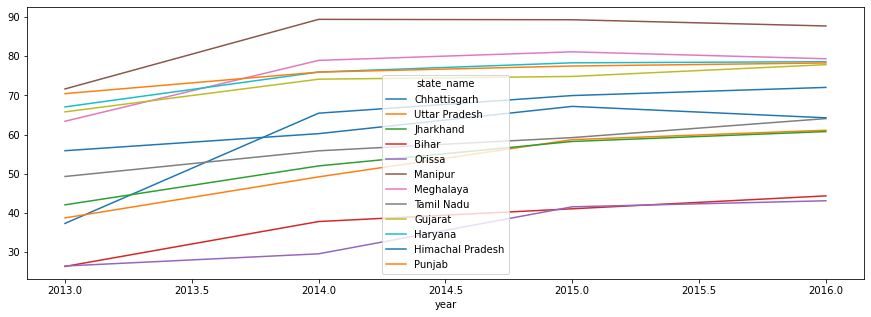

In [16]:
top = 12
metric = '%within_2years'  # %within_2years  cases_per_1L
dff2 = dff.set_index(['year', 'state_name'])[metric].unstack()
states2 = (dff2.loc[2016] - dff2.loc[2013]).sort_values(ascending=False).iloc[:top].index
dff2[states2].plot.line(figsize=(15, 5))

#### 2016: States -- %within_2years vs cases_per_1L

colored by regions, size by total cases filed in 2016

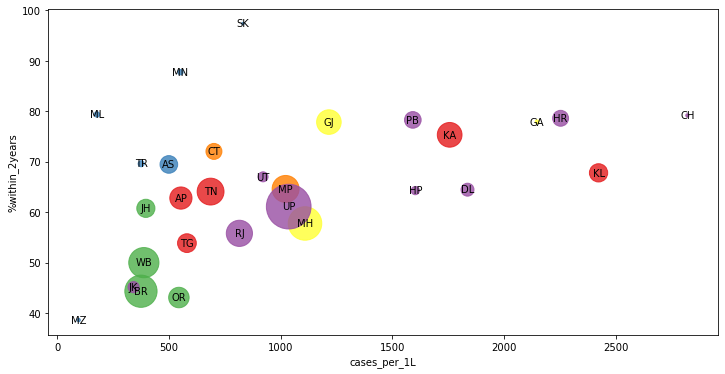

In [17]:
df_ = dff.query('year == 2016')
x = 'cases_per_1L'
y = '%within_2years'
s = df_['TOT_P'] / 1e5
color_map  =["#e41a1c","#377eb8" ,"#4daf4a" ,"#984ea3" ,"#ff7f00" ,"#ffff33"]
color_map = dict(zip(df_['regions'].unique(), color_map))
c = df_['regions'].map(color_map)
ax = df_.plot.scatter(x=x, y=y, s=s, c=c, alpha=0.8, figsize=(12, 6))
for i, p in df_.iterrows():
    ax.text(p[x], p[y], p['state_2code'], ha='center', va='center')